# COVID 19 FAQ 
- Question-Answer pairs for given categories
- User input gets classified into some category, upon which the appropriate answer is matched
- Data Sources: WHO, CDC, JHU, MoH KE



**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


In [1]:
%store -r __jhu_map

**Here's the JHU tracker**
[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [2]:
__jhu_map

Stored variables and their in-db values:
__jhu                     -> IPython.macro.Macro('### John Hopkins Dashboard - 
__jhu_map                 -> IPython.macro.Macro("get_ipython().run_line_magic(
__toggle_code             -> IPython.macro.Macro("get_ipython().run_line_magic(


In [3]:
%run utilz_includez.ipynb

In [4]:
import sys
sys.path.append('..')
sys.path.append('../envbin')
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet
from zmodel_cosine_similarity import ZCosineSimilarity

import random


logging.getLogger('zmoi').disabled = True

ZAPP_NAME = 'ncov19_tfidf_faq'

# Train Model
- Using TF-IDF Cosine Similarity. 

    - Easier to deploy on some cloud services than an MLP NN. 
    - FAQ data seems straightforward enough.
    - This model did well during exploration 

## 1. Load and clean data

In [5]:
### --- Dset HELPERS ---
def doFreqDist( list_text ):
    fq = nltk.FreqDist( list_text )
    print( "FreqDist of {} tokens.".format( fq.N() ) )
    # print( "Top 10 common tokens: \n{}".format( fq.most_common(10) ) )
    # plot most common
    fq.plot( 15) 
    plt.show()
    return fq

def printFAQ(dset=None, is_cleaned=False):
    if dset is not None:
        printHeadline('FAQ', 'Cleaned Dataset' if is_cleaned else 'Information on the FAQ dset')
        print( f"# Classes: {dset.getNumberClasses() }" )
        print( f"# Size training set: { len(dset.clean_data) if is_cleaned else len(dset.data) }" )    
        print( f"Vocab Size: { len(dset.getVocab()) }" )
        print( f"Lexical Richness: { len(dset.getVocab()) / len(dset.getWords()) }" )
        print( f"Threshold for N-gram Vs Seq: {dset.thresholdRatio() } <<< do Seq iff > 1500" )    
        print("-------")
        print( f"Example: Source phrase: {dset.data[0]}" )
        print( f"Example: Training phrase: {dset.x_index[0]}" )
        print( f"Example: Associated class: {dset.y_labelz[0]}" )
        print("")
        x = random.randint(0, len(dset.x_index)-1 )
        print( f"Example: Source phrase: {dset.data[x]}" )
        print( f"Example: Training phrase: {dset.x_index[x]}" )
        print( f"Example: Associated class: {dset.y_labelz[x]}" )
        print("-------")
        doFreqDist( dset.getWords() )


In [6]:
## 1. path to FAQ db
faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ      

## 2. create dset
dset = ZGsheetFaqDataSet()

## 3.read dataset
def readFAQdb(faq_path=faq_path, faq_typ=faq_typ):
    printHeadline('readFAQdb', 'Fetching FAQ Gsheet into responses and training_set')
    
    dset.initFromResource( faq_path, faq_typ )
    
    printFAQ(dset)
    


------ 1. READFAQDB : Fetching FAQ Gsheet into responses and training_set ------

------ 2. FAQ : Information on the FAQ dset ------
# Classes: 55
# Size training set: 190
Vocab Size: 399
Lexical Richness: 0.2645888594164456
Threshold for N-gram Vs Seq: 23.126201153106983 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: what is a pandemic?
Example: Associated class: pandemic_define

Example: Source phrase: can i make my cat, dog or pet sick
Example: Training phrase: can i make my cat, dog or pet sick
Example: Associated class: pets_infection
-------
FreqDist of 1508 tokens.


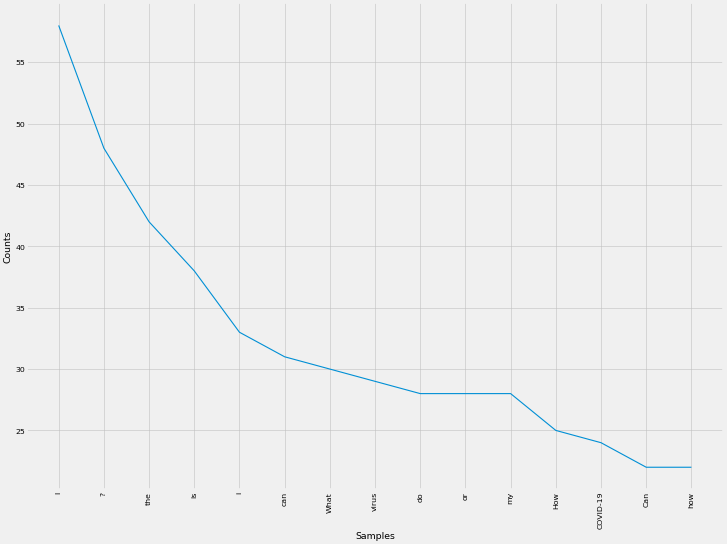

In [7]:
readFAQdb()

In [8]:
## create TFIDF Cosine Similarity model 
## TFIDF encoded data 

model = ZCosineSimilarity( ZAPP_NAME )

def resetAndTrainModel( n_gramz=(1,1) , log=True):
    if log:
        printHeadline('resetAndTrain', f"Updating Model @ ngramz={n_gramz}" ) 
    dset.encodeTrain(enc_type=zdataset.ZENC_TFIDF, ngramz=n_gramz )     
    model.build( dset.context , dset.encoded_matrix, dset.ylabelzAsInts(), dset.preprocessor)
#     print("TFIDF: {}".format( dset.context))
    

In [9]:
## Training Helpers
val_txt = ['Is corana deadly', 
           'What is corona', 
           "Should my pet get tested", 
           "Will mosquito bite infect me", 
          "Can I visit my elderly parents", 
          "Is there a vaccine"]

val_ylabz = ['covid19_define',
             'covid19_define',
            'pets_infection', 
            'covid19_spread_insects',
            'covid19_at_risk',
            'covid19_cure']

val_ylabz_int = dset.ylabelzAsInts(val_ylabz) 


def validateCosineModel(i=1, log=True):
    if log:
        print("\n{0} {1}. PREPROCESSING @ Validation Data {0}".format("-"*6, i))
    cleaned_txt = dset.preprocessPredict( val_txt)
    
    if log:
        for itx, otx in zip(val_txt, cleaned_txt):
            print("CLEANED: {} ===> {}".format(itx, otx))
        
    
    if log:
        print("\n{0} {1}. PREDICT @ Validation Data {0}".format("-"*6, i+1 ))
    acc, predicted_yz = model.validate( cleaned_txt, val_ylabz_int)
    
    for idx, txt, y in  zip( predicted_yz, val_txt, val_ylabz):
        cat,resp =  dset.getPredictedAtIndex( idx )
        if log:
            print("PREDICTED: {}:{} ===> {} for '{}' ".format(idx, y, cat, txt))
    #     print("\t{}\n".format(resp) )
    
    if log:
        print(">>> Predicted Accuracy: {} \n{}".format( acc, predicted_yz) ) 
    return acc
    

## 2. Train model using cleaned data

In [10]:
## Clean the data
updated_stopz = dset.getStopWords( ['virus', 'covid19', ]) ##Keeping covid and corona for @define
# print("STOPZ: ", ", ".join(updated_stopz) ) 



------ 3. CLEANING : WITH STOPZ ------

------ 4. FAQ : Cleaned Dataset ------
# Classes: 55
# Size training set: 190
Vocab Size: 282
Lexical Richness: 0.47474747474747475
Threshold for N-gram Vs Seq: 60.46901172529313 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: pandemic
Example: Associated class: pandemic_define

Example: Source phrase: While shool is out, how can I help my child to continue learning
Example: Training phrase: shool help child continue learning
Example: Associated class: covid19_school
-------
FreqDist of 594 tokens.


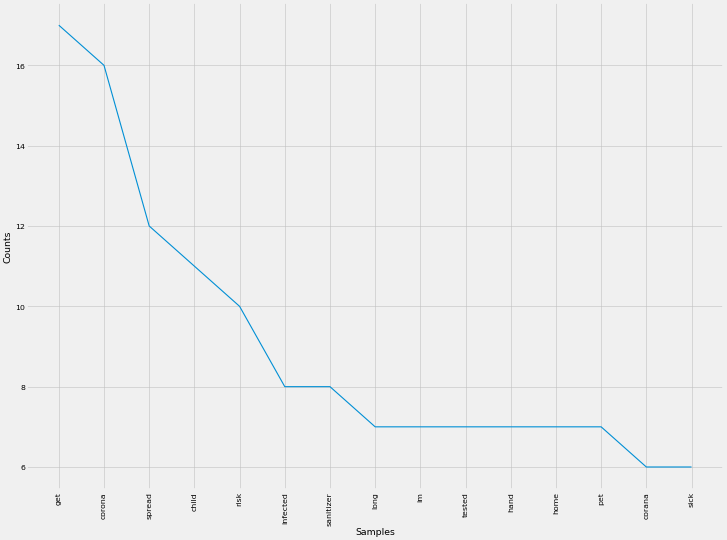

In [11]:
printHeadline('cleaning', 'WITH STOPZ')
clean_paramz = {
        'remove_stopwordz' : True,
        'stop_wordz' : updated_stopz, 
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }


dset.preprocess( **clean_paramz )     

printFAQ(dset, is_cleaned=True)

In [12]:
resetAndTrainModel()
base_acc = validateCosineModel(log=False)


------ 5. RESETANDTRAIN : Updating Model @ ngramz=(1, 1) ------



------ 6. CLEANING : WITHOUT STOPZ ------

------ 7. FAQ : Cleaned Dataset ------
# Classes: 55
# Size training set: 190
Vocab Size: 282
Lexical Richness: 0.47474747474747475
Threshold for N-gram Vs Seq: 60.46901172529313 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: pandemic
Example: Associated class: pandemic_define

Example: Source phrase: Will warm weather stop the outbreak
Example: Training phrase: warm weather stop outbreak
Example: Associated class: covid19_weather
-------
FreqDist of 594 tokens.


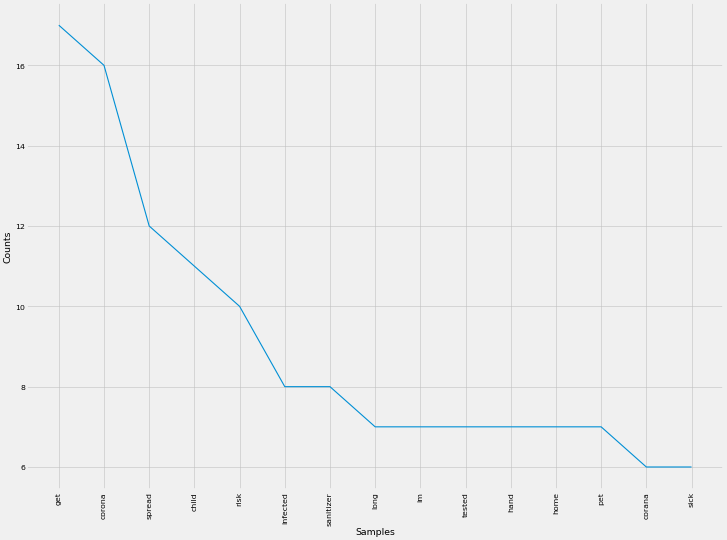

In [13]:
printHeadline('cleaning', 'WITHOUT STOPZ')

printFAQ(dset, is_cleaned=True)

In [14]:
resetAndTrainModel()
base_acc = validateCosineModel(log=False)


------ 8. RESETANDTRAIN : Updating Model @ ngramz=(1, 1) ------


## 3. Refine Model @ N-gram range

In [15]:

ZMODEL_ACC = {} 

ngramz = [ (1, 1), (1,2), (1,3), (2,2), (2,3), (3,3)]

clean_paramz_without_stopz = {
        'remove_stopwordz' : False,
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }
clean_paramz_asis = {
        'remove_stopwordz' : False,
        'remove_numberz' : False, 
        'lemmatized' : False, 
    }

config = {
    'lemma-stopz' : clean_paramz,
    'lemma-nostopz' : clean_paramz_without_stopz, 
    'stopz-only' : {**clean_paramz, **{'lemmatized':False } } , 
    'as-is' : clean_paramz_asis 
} 

In [16]:
## try different 
for k, conf in config.items():
    dset.preprocess( **conf )
    for ng in ngramz:
        resetAndTrainModel(n_gramz=ng, log=False)
        acc = validateCosineModel(log=False)
        ZMODEL_ACC[ f'{k}_{ng}gram'] = acc

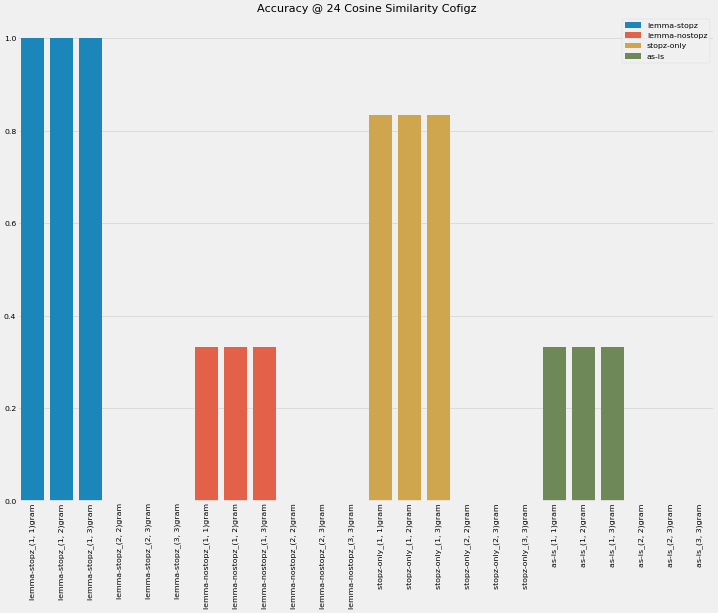

In [17]:
## Plot them 
def plotAcc(x_srcz, y_valz, huez, ttitle='Cosine Similarity'):
    g = sns.barplot( x=x_srcz, y=y_valz, hue=huez, dodge=False)
    g.set_title("Accuracy @ {} {} Cofigz".format(len(x_srcz), ttitle))
    g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.legend(loc='upper right')
    plt.show()

plotAcc( list(ZMODEL_ACC.keys()), list(ZMODEL_ACC.values()), [ x.split('_')[0] for x in ZMODEL_ACC.keys() ] )

## 4. Save Model for Reuse

In [18]:
## 1. Run with choice COnfig
choice_conf = {
        'remove_stopwordz' : True,
        'stop_wordz' : updated_stopz, 
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }

dset.preprocess( **choice_conf )
resetAndTrainModel(n_gramz=(1,1), log=False)
validateCosineModel(log=False)
print(model)

1.0

<class 'zmodel_cosine_similarity.ZCosineSimilarity'> ncov19_tfidf_faq with model file 'ncov19_tfidf_faq.zmd'


In [19]:
## 2. Save to file
model.dumpSave( ) 

In [20]:
acc, pred_y = model.validate( dset.preprocessPredict( val_txt), val_ylabz_int)
print(f"Target: {val_ylabz_int}\nPredicted:{pred_y}")

Target: [52, 52, 25, 41, 10, 24]
Predicted:[52 52 25 41 10 24]


In [21]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
print( f"Accuracy Score: { accuracy_score(val_ylabz_int, pred_y)}\n")
print( f"Classification Report: \n{ classification_report(val_ylabz_int, pred_y)}\n")
print( f"Confusion Matrix: \n { confusion_matrix(val_ylabz_int, pred_y)}")

Accuracy Score: 1.0

Classification Report: 
              precision    recall  f1-score   support

          10       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         1
          41       1.00      1.00      1.00         1
          52       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Confusion Matrix: 
 [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 2]]


### 2. Ditto @ NaiveBayes

In [23]:
from sklearn.naive_bayes import MultinomialNB

model_NB = MultinomialNB( )
model_NB.fit( dset.encoded_matrix , dset.y_labelz)
enc_q = dset.encodePredict( val_txt) 
pred_y = model_NB.predict( enc_q  )
pred_y = dset.ylabelzAsInts( pred_y)

print(f"Target: {val_ylabz_int}\nPredicted:{pred_y}\n")
print( f"Accuracy Score: { accuracy_score(val_ylabz_int, pred_y) }\n")
print( f"Classification Report: \n{ classification_report(val_ylabz_int, pred_y)}\n")
print( f"Confusion Matrix: \n { confusion_matrix(val_ylabz_int, pred_y)}")

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Target: [52, 52, 25, 41, 10, 24]
Predicted:[52, 52, 25, 10, 10, 10]

Accuracy Score: 0.6666666666666666

Classification Report: 
              precision    recall  f1-score   support

          10       0.33      1.00      0.50         1
          24       0.00      0.00      0.00         1
          25       1.00      1.00      1.00         1
          41       0.00      0.00      0.00         1
          52       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.47      0.60      0.50         6
weighted avg       0.56      0.67      0.58         6


Confusion Matrix: 
 [[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 2]]


### 3. Ditto @ Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

model_NB = RandomForestClassifier( n_estimators=dset.getNumberClasses() )
model_NB.fit( dset.encoded_matrix , dset.y_labelz)
enc_q = dset.encodePredict( val_txt) 
pred_y = model_NB.predict( enc_q  )
pred_y = dset.ylabelzAsInts( pred_y)

print(f"Target: {val_ylabz_int}\nPredicted:{pred_y}\n")
print( f"Accuracy Score: { accuracy_score(val_ylabz_int, pred_y) }\n")
print( f"Classification Report: \n{ classification_report(val_ylabz_int, pred_y)}\n")
print( f"Confusion Matrix: \n { confusion_matrix(val_ylabz_int, pred_y)}")

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Target: [52, 52, 25, 41, 10, 24]
Predicted:[52, 52, 25, 52, 52, 52]

Accuracy Score: 0.5

Classification Report: 
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       1.00      1.00      1.00         1
          41       0.00      0.00      0.00         1
          52       0.40      1.00      0.57         2

    accuracy                           0.50         6
   macro avg       0.28      0.40      0.31         6
weighted avg       0.30      0.50      0.36         6


Confusion Matrix: 
 [[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 2]]
